In [1]:
%load_ext tensorboard
import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import tensorrt as trt

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("TensorRt:", trt.__version__)

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

TARGET = "rucwar"
MIN_PER_CLASS = 50
OUTER_SPLITS = 2
INNER_SPLITS = 2
BATCH_SIZE = 64

SAMPLE_RATE = 16000
MAX_DURATION = 10 # seconds
NEG_POS_RATIO = 3
TRAIN_NEG_RATIO = 2
VAL_NEG_RATIO = 2
FILL_TYPE = "pad" # pad | tile
N_FRAMES = 64
FRAME_OVERLAP = int(np.ceil(N_FRAMES * 0.5))

SPECTROGRAM_SECONDS = 3

2025-08-29 17:02:53.366582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorRt: 10.13.2.6


In [2]:
from sklearn.model_selection import StratifiedGroupKFold
import os
import librosa

# birdclef sanity checks
def sanity_birdlcef(df: pd.DataFrame, target: str):
    # File integrity
    for r in df.itertuples():
        if os.path.isfile(r.path) is not True:
            print(f"[ERROR]: {r.path} is not valid!")
    
    # Dupicates
    dups = df['path'].duplicated().sum()  # or 'filename'
    print("Duplicate file rows:", dups)
    
    # Count summary
    print(f"Total Positives: {df[df['primary_label'] == target].shape[0]}")
    print(f"Total Negatives: {df[df['primary_label'] != target].shape[0]}")
    print(f"Avg samples per Class: {df['primary_label'].value_counts().mean():.0f}")



# Different functions for each dataset
def load_birdclef(audio_root, path, target, min_per_class = MIN_PER_CLASS):
    df = pd.read_csv(path)
    
    df["path"] = audio_root + "/" + df["primary_label"] + "/" + df["filename"]
    
    # Optional: drop rare classes (keeps CV stable)
    if min_per_class > 1:
        keep_labels = df["primary_label"].value_counts()
        keep_labels = keep_labels[keep_labels >= min_per_class].index
        df = df[df["primary_label"].isin(keep_labels)].reset_index(drop=True)
    
    # Perform sanity checks
    sanity_birdlcef(df, target)

    # Generate the binary labels, target = 1 else 0
    labels = (df['primary_label'] == target).astype(int).values
    
    # Group based on auther + time te prevent straddeling
    df["group_key"] = df["author"] + df["time"]
    
    return df
    

os.chdir("/home/joris/Thesis/new_attempt")

birdclef_df = load_birdclef("datasets/birdclef_2021/train_short_audio", "datasets/birdclef_2021/train_metadata.csv", target=TARGET)


Duplicate file rows: 0
Total Positives: 154
Total Negatives: 61815
Avg samples per Class: 168


In [3]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd

def make_nested_cv_splits(
    df: pd.DataFrame,
    target: str = TARGET,
    outer_splits: int = OUTER_SPLITS,
    inner_splits: int = INNER_SPLITS,
    random_state: int = RANDOM_STATE,
):
    """
    Build nested CV folds for binary BirdCLEF: target species = 1, others = 0.
    Uses StratifiedGroupKFold for both outer and inner splits to avoid leakage across groups.
    """
    
    # Binary labels for stratification
    y_all = (df["primary_label"] == target).astype(int).values
    groups_all = df["group_key"].astype(str).fillna("NA").values
    idx_all = np.arange(len(df))

    outer_kf = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    nested = []
    for k, (outer_tr_idx, outer_te_idx) in enumerate(outer_kf.split(idx_all, y=y_all, groups=groups_all), start=1):
        # Outer train/val pool and test set
        trval_idx = idx_all[outer_tr_idx]
        test_idx  = idx_all[outer_te_idx]

        y_trval   = y_all[outer_tr_idx]
        groups_trval = groups_all[outer_tr_idx]

        # Inner CV on the outer train/val pool
        inner_kf = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        inner_folds = []
        for j, (inner_tr_rel, inner_va_rel) in enumerate(inner_kf.split(trval_idx, y=y_trval, groups=groups_trval), start=1):
            # Map relative indices back to global indices
            inner_tr_idx = trval_idx[inner_tr_rel]
            inner_va_idx = trval_idx[inner_va_rel]

            inner_folds.append({
                "inner_fold": j,
                "inner_train_idx": inner_tr_idx,
                "inner_val_idx":   inner_va_idx,
            })

        nested.append({
            "outer_fold": k,
            "outer_train_idx": trval_idx,
            "outer_test_idx":  test_idx,
            "inner_folds": inner_folds,
            "train_pos_ratio": float(y_all[outer_tr_idx].mean()),
            "test_pos_ratio":  float(y_all[outer_te_idx].mean()),
        })

    return nested

    
    
cross_validation_sets = make_nested_cv_splits(birdclef_df)

In [4]:
import tensorflow_io as tfio
import subprocess

def load_ogg_ffmpeg(path, sr=16000):
    path = path.decode("utf-8")
    cmd = [
        "ffmpeg", "-i", path, "-f", "f32le",
        "-ac", "1", "-ar", str(sr), "pipe:1", "-loglevel", "quiet"
    ]
    out = subprocess.check_output(cmd)
    audio = np.frombuffer(out, np.float32)
    return audio

def load_ogg_librosa(path, sr=16000):
    path = path.decode("utf-8")
    y, sr = librosa.load(path, sr=SAMPLE_RATE)
    return y


def audio_pipeline(filename, augment=False, gaussian=0):
    # Load audio file as tensor 
    # audio_file = tf.numpy_function(load_ogg_ffmpeg, [filename, SAMPLE_RATE], tf.float32)
    audio_file = tf.numpy_function(load_ogg_librosa, [filename, SAMPLE_RATE], tf.float32)
    # audio_file, sr = librosa.load(filename.numpy(), sr=SAMPLE_RATE)
    
    # Remove last dimension
    waveform = audio_file[:SAMPLE_RATE * MAX_DURATION]
    
    if False:
        # Trim the noise from the audio
        position = tfio.audio.trim(waveform, axis=0, epsilon=0.1, name="Trim")
        
        start = position[0]
        stop = position[1]

        processed = waveform[start:stop]
    else:
        processed = waveform[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    # if gaussian > 0:
    #     processed = aug_gaussian_noise_snr(processed, gaussian)
    
    frame_count = tf.shape(processed)
    # Calculate end padding
    if (frame_count < SAMPLE_RATE):
        processed = waveform
        frame_count = tf.shape(processed)
    
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(tf.cast(1, tf.int64), 1 + tf.cast(((SAMPLE_RATE * SPECTROGRAM_SECONDS) / frame_count), tf.int64))
        
        processed = tf.repeat(processed, repeats)
        # Reduce size to max 
        processed = processed[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    if augment:
        # Fade in and out
        fade = tfio.audio.fade(
            processed, fade_in=1000, fade_out=2000, mode="logarithmic", name="Fade")
    else:
        fade = processed
    
    # Band filter
    from scipy import signal
    b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
    band_filter = tf.py_function(signal.lfilter, [b, a, fade], Tout=tf.float32, name="Filter")

    spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
    db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, -1)
    
    db_mel_spectrogram = tf.transpose(db_mel_spectrogram, perm=[1, 0 ,2])
    
    # db_mel_spectrogram = tf.ensure_shape(db_mel_spectrogram, (128, 188, 1))
    
    return db_mel_spectrogram

/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorfl

In [5]:
import tensorflow as tf

# --------- Pick a Binary Focal Cross-Entropy loss safely ----------
def get_binary_focal_loss(gamma=2.0, alpha=0.25):
    # 1) Native Keras (TF ≥ 2.12-ish)
    if hasattr(tf.keras.losses, "BinaryFocalCrossentropy"):
        return tf.keras.losses.BinaryFocalCrossentropy(gamma=gamma, alpha=alpha, from_logits=False)
    # 2) TensorFlow Addons fallback
    try:
        import tensorflow_addons as tfa
        return tfa.losses.SigmoidFocalCrossEntropy(gamma=gamma, alpha=alpha)
    except Exception:
        # 3) Minimal custom fallback (y_true∈{0,1}, y_pred∈[0,1])
        def focal_bce(y_true, y_pred):
            eps = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
            # standard BCE parts
            ce_pos = -tf.math.log(y_pred)
            ce_neg = -tf.math.log(1. - y_pred)
            # focal weighting
            loss_pos = alpha * tf.pow(1. - y_pred, gamma) * ce_pos * y_true
            loss_neg = (1. - alpha) * tf.pow(y_pred, gamma) * ce_neg * (1. - y_true)
            return tf.reduce_mean(loss_pos + loss_neg)
        return focal_bce

# --------- Simple binary CNN ----------
def build_binary_cnn(
    input_shape=(128, 64, 1),
    lr=1e-3,
    l2=1e-4,
    dropout=0.25,
    gamma=2.0,
    alpha=0.25,
):
    """
    Binary classifier for log-mel spectrograms (target vs non-target).
    Output: single sigmoid unit.
    Loss: Binary Focal Cross-Entropy (with safe fallbacks).
    """
    L2 = tf.keras.regularizers.l2(l2)
    Conv = tf.keras.layers.Conv2D
    focal_loss = get_binary_focal_loss(gamma=gamma, alpha=alpha)

    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 128x64 -> 64x32
    x = tf.keras.layers.Dropout(dropout)(x)

    # Block 2
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 64x32 -> 32x16
    x = tf.keras.layers.Dropout(dropout)(x)

    # Block 3
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 32x16 -> 16x8
    x = tf.keras.layers.Dropout(dropout)(x)

    # Head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=L2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # binary

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=focal_loss,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name='Brier score'),
            tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
            tf.keras.metrics.AUC(curve="ROC", name="auc"),
            tf.keras.metrics.AUC(curve="PR",  name="auprc"),
            tf.keras.metrics.Precision(name="precision", thresholds=0.5),
            tf.keras.metrics.Recall(name="recall", thresholds=0.5),
        ],
    )
    return model


In [6]:
import random
from typing import Sequence, Optional, Tuple

def _map_pos(x, y):
    return audio_pipeline(x, augment=True), y

def _map_neg(x, y):
    return audio_pipeline(x, augment=True), y

def plan_epoch_counts(n_pos_train: int, neg_pos_ratio: float = 2.0) -> Tuple[int, int]:
    P_pos = int(n_pos_train)               # see each positive once per epoch
    P_neg = int(round(neg_pos_ratio * P_pos))
    return P_pos, P_neg 

def sample_train_negatives(neg_all: Sequence[str], n_neg: int, seed: Optional[int] = None) -> Sequence[str]:
    n = min(n_neg, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n) if n > 0 else []

def make_fixed_val_negatives(neg_all: Sequence[str], n_pos_val: int, neg_pos_ratio: int = NEG_POS_RATIO, seed: int = RANDOM_STATE) -> Sequence[str]:
    n_neg = min(neg_pos_ratio * n_pos_val, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n_neg) if n_neg > 0 else []

def build_train_dataset(pos_files: Sequence[str], neg_files: Sequence[str], batch_size: int = BATCH_SIZE, shuffle: bool = True) -> tf.data.Dataset:
    labels_pos = tf.ones([len(pos_files)], dtype=tf.float32)
    labels_neg = tf.zeros([len(neg_files)], dtype=tf.float32)
    
    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), labels_pos)).map(_map_pos, num_parallel_calls=10)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files), labels_neg)).map(_map_neg, num_parallel_calls=10)

    ds = ds_pos.concatenate(ds_neg)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pos_files) + len(neg_files), seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).cache()
    return ds


def build_val_dataset(pos_files: Sequence[str], neg_files_fixed: Sequence[str], batch_size: int = BATCH_SIZE) -> tf.data.Dataset:
    y_pos = tf.ones([len(pos_files)],        dtype=tf.float32)
    y_neg = tf.zeros([len(neg_files_fixed)], dtype=tf.float32)

    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), y_pos)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=10)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files_fixed), y_neg)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=10)

    return ds_pos.concatenate(ds_neg).batch(batch_size).cache()

def build_file_lists(df: pd.DataFrame, idx, target=TARGET):
    sub = df.iloc[idx]
    pos = sub[sub.primary_label == target]["path"].tolist()
    neg = sub[sub.primary_label != target]["path"].tolist()
    return pos, neg

def make_epoch_train_dataset(pos_tr_all: Sequence[str], neg_tr_all: Sequence[str],
                             neg_pos_ratio: float = 2.0, batch_size: int = BATCH_SIZE, seed: Optional[int] = RANDOM_STATE) -> tf.data.Dataset:
    P_pos, P_neg = plan_epoch_counts(len(pos_tr_all), neg_pos_ratio)
    neg_epoch = sample_train_negatives(neg_tr_all, P_neg, seed=seed)
    return build_train_dataset(pos_tr_all, neg_epoch, batch_size=batch_size, shuffle=True)

def make_fixed_val_dataset(pos_va_all: Sequence[str], neg_va_all: Sequence[str],
                           neg_pos_ratio: int = 3, batch_size: int = BATCH_SIZE, seed: int = RANDOM_STATE) -> tf.data.Dataset:
    neg_fixed = make_fixed_val_negatives(neg_va_all, len(pos_va_all), neg_pos_ratio=neg_pos_ratio, seed=seed)
    return build_val_dataset(pos_va_all, neg_fixed, batch_size=batch_size)


def build_all_file_lists(df: pd.DataFrame, folds: dict, epoch: int = 0):
    out = []
    for fold in folds:
        outer_fold = int(fold["outer_fold"])
        outer_train_idx = fold["outer_train_idx"]
        outer_test_idx = fold["outer_test_idx"]
    
        # Build the file lists for the outer fold
        pos_tr_all, neg_tr_all = build_file_lists(df, outer_train_idx)    
        pos_test_all, neg_test_all = build_file_lists(df, outer_test_idx)
    

        # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
        outer_train_ds = make_epoch_train_dataset(
            pos_tr_all,
            neg_tr_all,
            neg_pos_ratio=TRAIN_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,
        )

        outer_test_ds = make_fixed_val_dataset(
            pos_test_all,
            neg_test_all,
            neg_pos_ratio=VAL_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,  # fixed per outer fold
        )
    
        
        inner_list = []
        for inner in fold["inner_folds"]:
            inner_fold = int(inner["inner_fold"])
            inner_train_idx = inner["inner_train_idx"]
            inner_val_idx   = inner["inner_val_idx"]

            pos_tr_all, neg_tr_all = build_file_lists(df, inner_train_idx)
            pos_va_all, neg_va_all = build_file_lists(df, inner_val_idx)

            # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
            train_ds = make_epoch_train_dataset(
                pos_tr_all,
                neg_tr_all,
                neg_pos_ratio=TRAIN_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold * 1_000 + epoch,
            )

            # Fixed validation and test datasets (reproducible seeds per outer/inner)
            val_ds = make_fixed_val_dataset(
                pos_va_all,
                neg_va_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold,
            )

            test_ds = make_fixed_val_dataset(
                pos_test_all,
                neg_test_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold,  # fixed per outer fold
            )

            inner_list.append({
                "inner_fold": inner_fold,
                "train_ds": train_ds,
                "val_ds":   val_ds,
                "test_ds":  test_ds,
            })
        out.append({"outer_fold": outer_fold, "train_ds":outer_train_ds, "test_ds":outer_test_ds, "inner": inner_list})
    return out
        

datasets = build_all_file_lists(birdclef_df, cross_validation_sets)

I0000 00:00:1756479783.228275    1659 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9509 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
per_fold_results = []

EPOCHS_PER_FOLD = 50

hparams_per_fold = {
    0: {"lr":1e-3, "gamma":1.0, "alpha":0.25},
    1: {"lr":1e-3, "gamma":2.0, "alpha":0.5},
    2: {"lr":1e-3, "gamma":3.0, "alpha":0.75},
    3: {"lr":1e-3, "gamma":4.0, "alpha":0.25},
    4: {"lr":1e-3, "gamma":5.0, "alpha":0.25},
}

for outer_fold in datasets:
    print(f"[INFO]: Running outer fold: {outer_fold["outer_fold"]}")
    inner_scores = []
    for inner_fold in outer_fold["inner"]:
        print(f"[INFO]: Running inner fold: {inner_fold["inner_fold"]}")
        model = build_binary_cnn(input_shape=(128, 188, 1), 
                                 lr=hparams_per_fold[inner_fold["inner_fold"]]["lr"], 
                                 gamma=hparams_per_fold[inner_fold["inner_fold"]]["gamma"], 
                                 alpha=hparams_per_fold[inner_fold["inner_fold"]]["alpha"])

        model.fit(
            inner_fold["train_ds"],
            epochs = EPOCHS_PER_FOLD,
            validation_data=inner_fold["val_ds"],
            steps_per_epoch=8,
            verbose=0
        )
        
        
        vals = model.evaluate(inner_fold["test_ds"], verbose=0)
        print(model.metrics_names)
        print(vals)
        inner_scores.append(vals[2])
    
    mean_test_acc = np.mean(inner_scores)
    print(f"Inner CV mean test acc: {mean_test_acc:.3f}")
    
    # Retrain with the best parameters
    best_inner = np.argmax(inner_scores)
    
    model = build_binary_cnn(input_shape=(128, 188, 1), 
                                lr=hparams_per_fold[best_inner]["lr"], 
                                gamma=hparams_per_fold[best_inner]["gamma"], 
                                alpha=hparams_per_fold[best_inner]["alpha"])
    model.fit(
        outer_fold["train_ds"],
        epochs = EPOCHS_PER_FOLD,
        verbose=0
    )
    
    vals = model.evaluate(outer_fold["test_ds"], verbose=0)
    per_fold_results.append(vals[2])

print(per_fold_results)

[INFO]: Running outer fold: 1
[INFO]: Running inner fold: 1


2025-08-29 17:03:17.136017: I external/local_xla/xla/service/service.cc:163] XLA service 0x784f5801e9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-29 17:03:17.136040: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-08-29 17:03:17.218655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-29 17:03:17.613418: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-29 17:03:17.836415: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:03:17.

['loss', 'compile_metrics']
[0.5869250893592834, 0.24286945164203644, 0.6761904954910278, 0.7418367862701416, 0.6435135006904602, 1.0, 0.02857142873108387]
[INFO]: Running inner fold: 2


2025-08-29 17:04:00.558425: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:04:00.558468: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:04:00.764837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-08-29 17:04:00.987316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

['loss', 'compile_metrics']
[0.29516953229904175, 0.23851752281188965, 0.6666666865348816, 0.48515307903289795, 0.33108481764793396, 0.0, 0.0]
Inner CV mean test acc: 0.671


2025-08-29 17:04:32.221471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:04:32.221515: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:04:32.221523: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:04:32.598283: I external/l

[INFO]: Running outer fold: 2
[INFO]: Running inner fold: 1


2025-08-29 17:05:07.401653: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:05:07.401693: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:05:07.642253: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-08-29 17:05:07.806982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

['loss', 'compile_metrics']
[0.5646078586578369, 0.24886830151081085, 0.6547619104385376, 0.6759141683578491, 0.47014299035072327, 0.4693877696990967, 0.2738095223903656]
[INFO]: Running inner fold: 2


2025-08-29 17:05:33.606971: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:05:33.607017: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:05:33.773565: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-08-29 17:05:34.020850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

['loss', 'compile_metrics']
[2.716869831085205, 0.5663859248161316, 0.3452380895614624, 0.5560516119003296, 0.3761445879936218, 0.3360323905944824, 0.988095223903656]
Inner CV mean test acc: 0.500


2025-08-29 17:06:01.867644: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-29 17:06:02.038088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-08-29 17:06:02.186421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 16 bytes spill stores, 16 bytes spill loads



[0.6952381134033203, 0.6626983880996704]


In [8]:
# Now we can train the actual model we use for the soundscapes based on the best configuration

model = build_binary_cnn(input_shape=(128, 188, 1), 
                         lr=hparams_per_fold[best_inner]["lr"], 
                         gamma=hparams_per_fold[best_inner]["gamma"], 
                         alpha=hparams_per_fold[best_inner]["alpha"])
model.fit(
    datasets[np.argmax(per_fold_results)]["train_ds"],
    epochs = EPOCHS_PER_FOLD,
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - Brier score: 0.2525 - acc: 0.5675 - auc: 0.4915 - auprc: 0.3325 - loss: 0.4623 - precision: 0.2727 - recall: 0.1786
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - Brier score: 0.2350 - acc: 0.6151 - auc: 0.5522 - auprc: 0.3923 - loss: 0.3816 - precision: 0.4133 - recall: 0.3690
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - Brier score: 0.2180 - acc: 0.6587 - auc: 0.6011 - auprc: 0.4286 - loss: 0.3634 - precision: 0.4500 - recall: 0.1071
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - Brier score: 0.2220 - acc: 0.6389 - auc: 0.5897 - auprc: 0.4061 - loss: 0.3636 - precision: 0.3600 - recall: 0.1071
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - Brier score: 0.2195 - acc: 0.6786 - auc: 0.6047 - auprc: 0.4889 - loss: 0.3553 - precision: 0.5333 - recall: 0.2857
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - Brier score: 0.2147 - acc: 0.6746 - auc: 0.6421 - auprc: 0.4894 - loss: 0.3483 - precision: 0.5278 - recall: 0.22

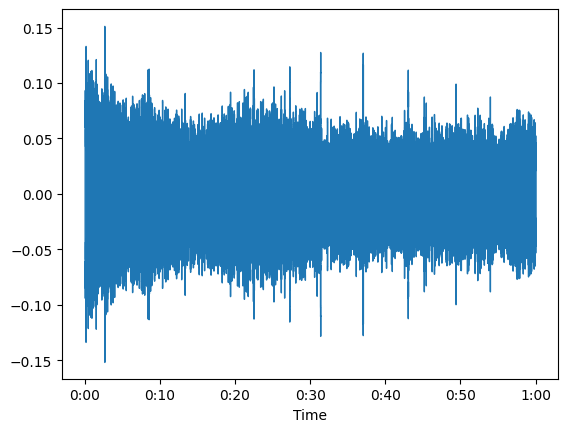

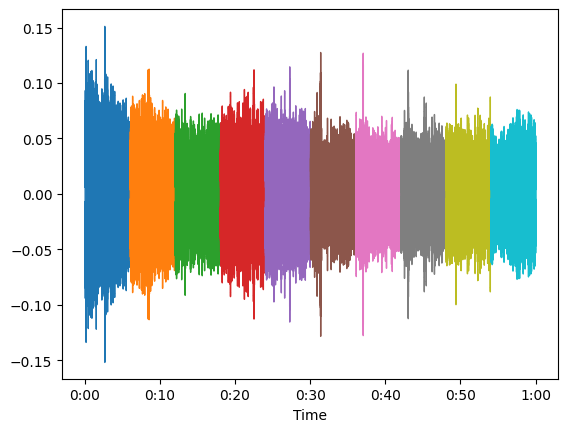

In [16]:
import math
import matplotlib.pyplot as plt

# Load a soundscape
y, sr = librosa.load("datasets/birdclef_2021/train_soundscapes/18003_COR_20190904.ogg", sr=SAMPLE_RATE)

SECONDS = 6
BYTES_PER_SECOND = SECONDS * SAMPLE_RATE

# Cut it into chunks of 5 seconds
chunks = []
for i in range(0, math.ceil(len(y)/BYTES_PER_SECOND)):
    chunk = y[i*BYTES_PER_SECOND:(i+1)*BYTES_PER_SECOND]
    chunks.append(chunk)
    
count = 10
librosa.display.waveshow(y[:count*BYTES_PER_SECOND], sr=SAMPLE_RATE)
plt.show()

for i in range(count):
    librosa.display.waveshow(chunks[i], offset=i*SECONDS, sr=SAMPLE_RATE)
    
plt.show()
# Listen to the first sample
import IPython.display
IPython.display.Audio(chunks[0], rate=SAMPLE_RATE)

(128, 188)


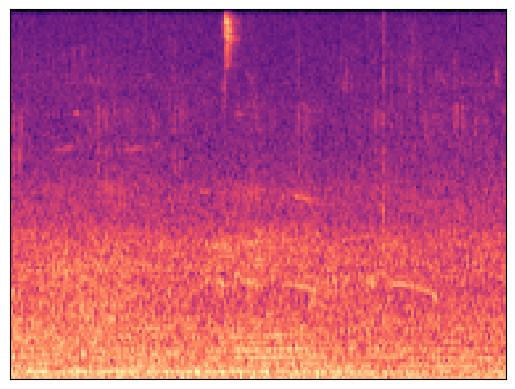

In [17]:
from librosa._typing import _STFTPad

def generate_mel_spectrogram(audio, sr = SAMPLE_RATE, n_fft=1024, n_mels=128, hop_length=512, win_length=None, 
                       window:str='hann', center=True, pad_mode:_STFTPad='constant', power=2.0, fmin=200, 
                       fmax=8000, norm='slaney'):
    # Generate mel spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode, power=power, fmin=fmin, fmax=fmax, norm=norm)
    # Convert to dB
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

# Convert the chunks into spectrograms
for i, chunk in enumerate(chunks):
    chunks[i] = generate_mel_spectrogram(chunk)

print(chunks[i].shape)
    
plt.show()
librosa.display.specshow(chunks[0])

In [ ]:
# Load the labels
soundscape_labels = pd.read_csv("datasets/birdclef_2021/train_soundscape_labels.csv")

# Filter for the current file
CURRENT_SITE = "COR"
CURRENT_ID = 18003

soundscape_labels = soundscape_labels[(soundscape_labels["site"] == CURRENT_SITE) & (soundscape_labels["audio_id"] == CURRENT_ID)]

chunks = np.array(chunks)
# Predict the labels with the model
predictions = model.predict(chunks)

print(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[0.19019054]
 [0.19410554]
 [0.21727489]
 [0.3149692 ]
 [0.30120203]
 [0.27520093]
 [0.29307082]
 [0.2556387 ]
 [0.29434374]
 [0.28527153]
 [0.27143756]
 [0.21712242]
 [0.24920379]
 [0.28856498]
 [0.28294381]
 [0.3107814 ]
 [0.3977297 ]
 [0.34289697]
 [0.3023327 ]
 [0.18035008]
 [0.19935812]
 [0.18655914]
 [0.22760677]
 [0.16084336]
 [0.23603553]
 [0.23855454]
 [0.28941464]
 [0.24219964]
 [0.2937918 ]
 [0.30574936]
 [0.28916812]
 [0.22319868]
 [0.31118128]
 [0.29819706]
 [0.29272914]
 [0.19636786]
 [0.27454302]
 [0.22563978]
 [0.26868093]
 [0.2860629 ]
 [0.32935306]
 [0.29090255]
 [0.27709067]
 [0.28982666]
 [0.25671566]
 [0.29642347]
 [0.31945872]
 [0.32683915]
 [0.2093353 ]
 [0.42328596]
 [0.20723186]
 [0.21772797]
 [0.23824608]
 [0.3226743 ]
 [0.24683066]
 [0.19192229]
 [0.29715037]
 [0.3418103 ]
 [0.50888383]
 [0.2339918 ]
 [0.35458225]
 [0.49556243]
 [0.3240302 ]
 [0.41610765]
 [0.80856156]
 [0.4969111 ]
 [0.31061926]
 [0.6904318 ]
 [0.270174